# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 30
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)
    def _load_image(self, image_path):
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-b59c19bddbd4>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.2341, 0.1875, 0.1630,  ..., 0.1162, 0.1090, 0.1001],
         [0.2260, 0.1964, 0.1649,  ..., 0.1168, 0.1055, 0.1001],
         [0.2255, 0.2037, 0.1660,  ..., 0.0974, 0.0974, 0.1095],
         ...,
         [0.1824, 0.1875, 0.1808,  ..., 0.1628, 0.2085, 0.2211],
         [0.1843, 0.1832, 0.1846,  ..., 0.1364, 0.1700, 0.2107],
         [0.1967, 0.1883, 0.1827,  ..., 0.1313, 0.1431, 0.1794]],

        [[0.2998, 0.2350, 0.2010,  ..., 0.1273, 0.1154, 0.1013],
         [0.2850, 0.2483, 0.2015,  ..., 0.1201, 0.1079, 0.1023],
         [0.2855, 0.2586, 0.2004,  ..., 0.0968, 0.0946, 0.1098],
         ...,
         [0.2241, 0.2302, 0.2201,  ..., 0.2036, 0.2775, 0.2937],
         [0.2254, 0.2270, 0.2270,  ..., 0.1656, 0.2196, 0.2786],
         [0.2440, 0.2339, 0.2265,  ..., 0.1502, 0.1688, 0.2246]],

        [[0.4460, 0.3458, 0.2864,  ..., 0.1970, 0.1789, 0.1557],
         [0.4234, 0.3662, 0.2886,  ..., 0.1814, 0.1675, 0.1574],
         [0.4262, 0.3865, 0.2900,  ..., 0.1502, 0.1476, 0.

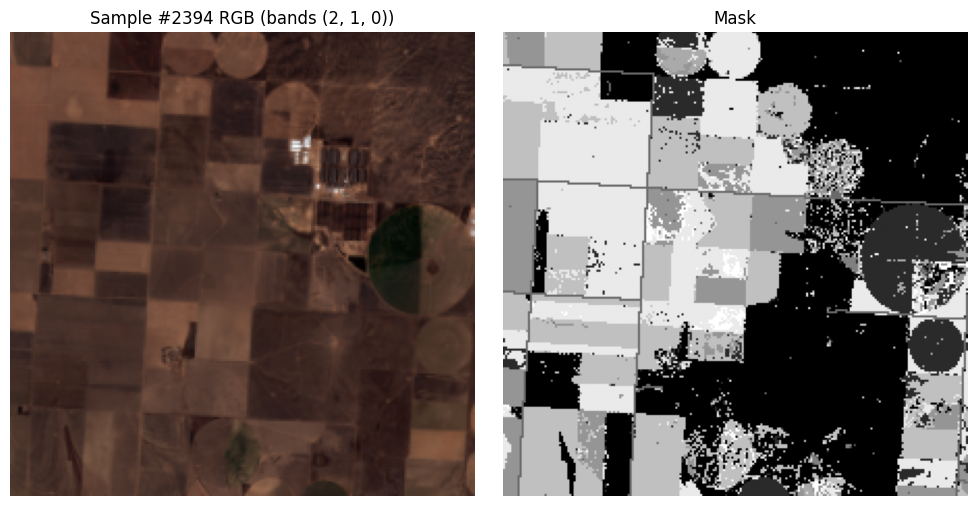

tensor([[[0.0754, 0.0951, 0.0877,  ..., 0.0820, 0.0935, 0.0951],
         [0.0760, 0.0940, 0.0957,  ..., 0.0910, 0.0954, 0.0918],
         [0.0702, 0.0973, 0.0932,  ..., 0.0896, 0.0987, 0.0984],
         ...,
         [0.0440, 0.0443, 0.0456,  ..., 0.0631, 0.0609, 0.0555],
         [0.0445, 0.0467, 0.0459,  ..., 0.0741, 0.0672, 0.0588],
         [0.0437, 0.0443, 0.0448,  ..., 0.0776, 0.0765, 0.0525]],

        [[0.0941, 0.1204, 0.1144,  ..., 0.1102, 0.1256, 0.1226],
         [0.0919, 0.1196, 0.1229,  ..., 0.1214, 0.1261, 0.1182],
         [0.0879, 0.1231, 0.1206,  ..., 0.1204, 0.1293, 0.1258],
         ...,
         [0.0359, 0.0362, 0.0369,  ..., 0.0907, 0.0795, 0.0793],
         [0.0354, 0.0396, 0.0414,  ..., 0.1100, 0.0944, 0.0795],
         [0.0364, 0.0359, 0.0367,  ..., 0.1144, 0.1189, 0.0746]],

        [[0.0576, 0.0894, 0.0778,  ..., 0.0753, 0.0938, 0.0964],
         [0.0588, 0.0920, 0.0927,  ..., 0.0864, 0.0948, 0.0915],
         [0.0458, 0.1048, 0.0913,  ..., 0.0873, 0.1062, 0.

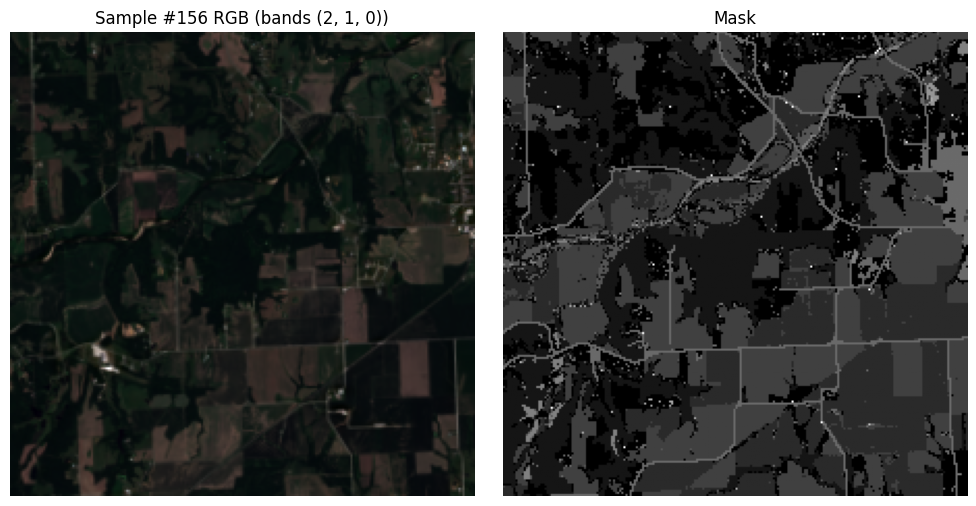

In [7]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [8]:
model = Unet(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-8-2ebd06ad12a5>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

In [ ]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Epoch 1/30:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-5-b59c19bddbd4>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/30: 100%|██████████| 78/78 [14:10<00:00, 10.91s/it]


[Epoch  0] Loss:  2.5624, Acc:   0.1063, IoU:   0.0296, Dice:  0.0386, mIoU:  0.0248


Epoch 1/30 [Val]: 100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


[Epoch  0] Loss: 2.3186, Acc: 0.1397, IoU: 0.0508, Dice: 0.0671, mIoU: 0.0477


Epoch 2/30: 100%|██████████| 78/78 [06:08<00:00,  4.72s/it]


[Epoch  1] Loss:  2.1896, Acc:   0.1684, IoU:   0.0825, Dice:  0.0879, mIoU:  0.0650


Epoch 2/30 [Val]: 100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


[Epoch  1] Loss: 2.0331, Acc: 0.1931, IoU: 0.1115, Dice: 0.1133, mIoU: 0.0849


Epoch 3/30: 100%|██████████| 78/78 [06:06<00:00,  4.70s/it]


[Epoch  2] Loss:  1.9638, Acc:   0.2278, IoU:   0.1366, Dice:  0.1240, mIoU:  0.0928


Epoch 3/30 [Val]: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


[Epoch  2] Loss: 1.8940, Acc: 0.2402, IoU: 0.1487, Dice: 0.1308, mIoU: 0.0985


Epoch 4/30: 100%|██████████| 78/78 [06:02<00:00,  4.64s/it]


[Epoch  3] Loss:  1.8532, Acc:   0.2472, IoU:   0.1538, Dice:  0.1425, mIoU:  0.1072


Epoch 4/30 [Val]: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


[Epoch  3] Loss: 1.8272, Acc: 0.2814, IoU: 0.1702, Dice: 0.1482, mIoU: 0.1116


Epoch 5/30: 100%|██████████| 78/78 [06:02<00:00,  4.65s/it]


[Epoch  4] Loss:  1.7674, Acc:   0.2905, IoU:   0.1820, Dice:  0.1550, mIoU:  0.1168


Epoch 5/30 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


[Epoch  4] Loss: 1.7459, Acc: 0.2988, IoU: 0.1846, Dice: 0.1631, mIoU: 0.1225


Epoch 6/30: 100%|██████████| 78/78 [05:46<00:00,  4.44s/it]


[Epoch  5] Loss:  1.7160, Acc:   0.3012, IoU:   0.1903, Dice:  0.1626, mIoU:  0.1231


Epoch 6/30 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


[Epoch  5] Loss: 1.6883, Acc: 0.3078, IoU: 0.1946, Dice: 0.1686, mIoU: 0.1286


Epoch 7/30: 100%|██████████| 78/78 [06:03<00:00,  4.66s/it]


[Epoch  6] Loss:  1.6789, Acc:   0.2930, IoU:   0.1882, Dice:  0.1705, mIoU:  0.1297


Epoch 7/30 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.59s/it]


[Epoch  6] Loss: 1.6897, Acc: 0.3246, IoU: 0.2072, Dice: 0.1709, mIoU: 0.1297


Epoch 8/30: 100%|██████████| 78/78 [05:59<00:00,  4.61s/it]


[Epoch  7] Loss:  1.6477, Acc:   0.3025, IoU:   0.1967, Dice:  0.1755, mIoU:  0.1342


Epoch 8/30 [Val]: 100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


[Epoch  7] Loss: 1.6733, Acc: 0.3265, IoU: 0.2101, Dice: 0.1770, mIoU: 0.1360


Epoch 9/30: 100%|██████████| 78/78 [05:56<00:00,  4.57s/it]


[Epoch  8] Loss:  1.6197, Acc:   0.3144, IoU:   0.2069, Dice:  0.1825, mIoU:  0.1400


Epoch 9/30 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.61s/it]


[Epoch  8] Loss: 1.6303, Acc: 0.3096, IoU: 0.2043, Dice: 0.1810, mIoU: 0.1405


Epoch 10/30: 100%|██████████| 78/78 [05:59<00:00,  4.61s/it]


[Epoch  9] Loss:  1.5966, Acc:   0.3223, IoU:   0.2141, Dice:  0.1868, mIoU:  0.1435


Epoch 10/30 [Val]: 100%|██████████| 20/20 [01:29<00:00,  4.48s/it]


[Epoch  9] Loss: 1.6313, Acc: 0.3260, IoU: 0.2143, Dice: 0.1831, mIoU: 0.1412


Epoch 11/30: 100%|██████████| 78/78 [05:30<00:00,  4.23s/it]


[Epoch 10] Loss:  1.5643, Acc:   0.3365, IoU:   0.2263, Dice:  0.1934, mIoU:  0.1491


Epoch 11/30 [Val]:  55%|█████▌    | 11/20 [01:01<00:47,  5.23s/it]

In [ ]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [ ]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


In [ ]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")
